# Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy as sp
import os
import glob
import pandas as pd
from datetime import datetime, timedelta
import collections
import matplotlib.cm as cm
#plt.rcdefaults() #Setting default color of output plots. No need in jupyter lab. Only for notebook with dark theme
# For interactive plots

plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib widget

# TODO:
    
   1) GRB ID SHOULD BE USED AS INPUT IN MOST FUNCTIONS!! IMPLEMENT THIS 
   2) Correct concatination of multiple files. GRB_ID is used to locate list of files
   2) Use GRBID as input in plotting function, not filename. Don't need this right now tho. FOR LED AND HED
   3) Redo all the plots ...

# Paths

In [1]:
path_HED = "/Home/siv30/wad005/master/GRB/MATLAB/output/file_mat_TGF/"              #UiB
path_LED = "/Home/siv30/wad005/master/GRB/MATLAB/CZT_calibration/file_mat_CZT_TGF/" #UiB
#path_HED = "/Users/andreas/phys/master/GRB/MATLAB/output/file_mat_TGF/"               #MAC
#path_LED = "/Users/andreas/phys/master/GRB/MATLAB/CZT_calibration/file_mat_CZT_TGF/"  #MAC

# Dict creation

In [4]:
trig_dict_HED = {"GRB180720":["2018_07_20_14_21_48","2018_07_20_14_21_51","2018_07_20_14_21_56","2018_07_20_14_21_57","2018_07_20_14_22_09"],
                 "GRB181222":["2018_12_22_20_11_36"],
                 "GRB190206":["2019_02_06_03_49_28"],
                 "GRB190305":["2019_03_05_13_05_19"],
                 "GRB190501":["2019_05_01_05_23_22"],
                 "GRB190606":["2019_06_06_01_55_07"],
                 "GRB190615":["2019_06_15_14_42_21"],
                 "GRB190813":["2019_08_13_12_00_49"],
                 "GRB190825":["2019_08_25_21_04_55","2019_08_25_21_04_53"], 
                 "GRB190829":["2019_08_29_19_56_40"],
                 "GRB190906":["2019_09_06_01_04_51"],
                 "GRB191001":["2019_10_01_06_41_52"],
                 "GRB191004":["2019_10_04_18_07_03"],
                 "GRB191119":["2019_11_19_10_41_06"],
                 "GRB191221":["2019_12_21_20_39_10","2019_12_21_20_39_11","2019_12_21_20_39_12","2019_12_21_20_39_13","2019_12_21_20_39_15"],
                 "GRB200412":[],# long list
                 "GRB200521":["2020_05_21_12_16_39"],
                 "GRB200716":["2020_07_16_22_57_40"],
                 "GRB200925":["2020_09_25_21_50_31"],
                 "GRB201227":["2020_12_27_15_14_06"]
            }
trig_dict_HED = collections.OrderedDict(sorted(trig_dict_HED.items())) #Sorting the keys in decending order. Now trig_dict_HED is an OderedDict type

for key in trig_dict_HED.keys():
    trig_dict_HED[key].sort() #sorting files in increasing order


In [5]:
trig_dict_LED = {"GRB181227":["2018.12.27_06.17.04.210500_Fulltrigger","2018_12_27_06_17_09.775992_Fulltrigger","2018_12_27_06_17_10.800851_Fulltrigger"],
                "GRB190117":["2019.01.17_08.50.42.939689_Fulltrigger"],
                 "GRB190420":["2019.04.20_23.32.24.931211_Fulltrigger"],
                 "GRB190501":["2019.05.01_05.23.21.736797_Fulltrigger"],
                 "GRB190615":["2019.06.15_14.42.22.741579_Fulltrigger"],
                 "GRB190628":["2019.06.28_04.23.32.512290_Fulltrigger"],
                 "GRB190813":["2019.08.13_12.00.48.801260_Fulltrigger"],
                 "GRB190825":["2019.08.25_21.04.54.439617_Fulltrigger","2019.08.25_21.04.56.395859_Fulltrigger"],
                 "GRB190906":["2019.09.06_01.04.52.014004_Fulltrigger"],
                 "GRB191001":["2019.10.01_06.41.51.631214_Fulltrigger"],
                 "GRB191004":["2019.10.04_18.07.03.402478_Fulltrigger"],
                 "GRB191119":["2019.11.19_10.41.05.239944_Fulltrigger"],
                 "GRB191221":["2019.12.21_20.39.11.939846_Fulltrigger","2019.12.21_20.39.12.939997_Fulltrigger","2019.12.21_20.39.13.940233_Fulltrigger",
                              "2019.12.21_20.39.15.106045_Fulltrigger","2019.12.21_20.39.17.252498_Fulltrigger"]
                 
                }
trig_dict_LED = collections.OrderedDict(sorted(trig_dict_LED.items())) #Sorting the keys in decending order. Now trig_dict_HED is an OderedDict type

for key in trig_dict_LED.keys():
    trig_dict_LED[key].sort() #sorting files in increasing order


# Functions for handling matlab files

## CZT function

In [6]:
def read_matlab_file_with_CZT_data(filename):
    '''Read matlab file with ASIM CZT data from the low energy detector (LED)

    tus: relative time in microseconds (excluded multihits)
    erg: energy channel (excluded multihits)
    energy_keV: energy in keV (excluded multihits)
    tus_keep_multihit: relative time in microseconds (included multihits)
    erg_keep_multihit: energy channel (included multihits)
    multihit_indx: multihit index 0-4. 0->1 1->2// 0: tus=105, 1: tus=110,110 (two counts)
    '''
    mat = scipy.io.loadmat(path_LED + "%s.mat" % (filename))

    #keV_spectra = mat['keV_spectra_total_fulltrigger']

    # Included multihits. Important for light curves
    tus_keep_multihit = np.array(mat['tus_keep_multihit_fulltrigger'])[:,0] # relative time in microseconds
    erg_keep_multihit = np.array(mat['erg_keep_multihit_fulltrigger'])[0,:] # energy channel (unreliable for multi hits)
    multihit_indx = np.array(mat['multihit_fulltrigger'])[0,:] # multihit index. How many multihits in count. (0=1 count, 1=2 counts, 2=3 counts...)
    
    # The multihits are removed as they don't have a reliable energy estimate
    erg = np.array(mat['erg_fulltrigger'])[0,:] # energy channel of CZT pixel
    tus = np.array(mat['tus_fulltrigger'])[:,0] # relative time in microseconds
    energy_keV = np.array(mat['pixel_energy_fulltrigger']).flatten() # energy in keV of CZT pixel
    date = mat['T_ref_char'][0] #raw datetime
    
    #Logic that checks for array lengths
    try:
        length = len(tus_keep_multihit)
        if any(len(lst) != length for lst in [erg_keep_multihit, multihit_indx]):
        # at least one list has a different length
            raise ValueError("Arrays have different lengths")
            
        t_temp = []
        erg_temp = []
        energy_keV_temp = []
        
        for index, i in enumerate(multihit_indx):
            for j in np.arange(0,i+1): #adding i+1 times the tus_count
                t_temp.append(tus_keep_multihit[index])
                erg_temp.append(erg_keep_multihit[index])

         
        tus_keep_multihit_ntimes =  np.array(t_temp) #array of tus. Multihit index decides how many times the tus is appended
        erg_keep_multihit_ntimes = np.array(erg_temp) #array of erg. Multihit index decides how many times the erg is appended
        
        
        return tus, erg, energy_keV, tus_keep_multihit_ntimes, erg_keep_multihit_ntimes, multihit_indx, date 
    
    except ValueError as ve:
        print("Function aborted because of: " + str(ve))
        print("Length of arrays: ")
        for lst in [tus_keep_multihit, erg_keep_multihit, multihit_indx]:
            print(len(lst))

## BGO function

In [7]:
def read_matlab_file_with_BGO_data(matlabfilename):
    '''Read matlab file with ASIM BGO data from the high energy detector (HED)

    tus: relative times in microseconds.
    erg: energy channel (needs to be calibrated to keV using calibration coeff from https://git.app.uib.no/ASIM-MXGS/IN-FLIGHT_CALIBRATION_BGO/-/tree/master/CALIBRATION_COEFS )
    typ: normal (0), fast(1), valley (3), or overflow event (2 or 4 not )
    adr: BGO address 1-12
    dau: dau address 1-4
    det: detector address 1-3
    DetCol: RGB color
    
    - Kepping only normal (0) and fast (1) events
    '''
    matlabfile_TGF = path_HED + '%s.mat' % matlabfilename
    
    mat = scipy.io.loadmat(matlabfile_TGF)
    
    tus = mat['tus'].flatten()
    erg = mat['erg'].flatten()
    DetCol = mat['DetCol'] # Investigate this matrix
    adr = mat['adr'].flatten()
    dau = mat['dau'].flatten()
    det = mat['det'].flatten()
    typ = mat['typ'].flatten()
    
    date = mat['date'][0] #raw datetime
    
    
    try:
        length = len(tus)
        if any(len(lst) != length for lst in [erg, typ, adr, dau, det]):
        # at least one list has a different length
            raise ValueError("Arrays have different lengths")
            
        mask = np.where((typ != 0) & (typ != 1)) #finding indecies of vallays and overflow events
        
        # removing those indecies
        tus = np.delete(tus,mask)
        erg = np.delete(erg,mask)
        adr = np.delete(adr,mask)
        dau = np.delete(dau,mask)
        det = np.delete(det,mask)
        typ = np.delete(typ,mask)
        
        
        return tus, erg, typ, adr, dau, det, DetCol, date
    
    except ValueError as ve:
        print("Function aborted because of: " + str(ve))
        print("Length of arrays: ")
        for lst in [tus,erg, typ, adr, dau, det]:
            print(len(lst))

# Plotting functions

## LED

In [17]:
def plot_LED(grb_id=None, tus_arr = None, LED_filename=None, binsize=10,start_range =0, end_range=0, T0 =None):
    """ Can switch between plotting by grb_id, tus_arr and LED_filename. Only one of the options at the time.
    plot_LED function can also find the background when start_range and end_range is specified"""
    
    binsize = binsize*1e3 #converting to microseconds
    start_range = start_range*1e3 #converting to microseconds
    end_range = end_range*1e3
    
    
    #switch for input
    try:
        if LED_filename != None and grb_id == None and tus_arr == None:
            tus_LED, erg_LED, energy_keV_LED, tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED, date = read_matlab_file_with_CZT_data(
                LED_filename)
            T0 = datetime.strptime(date, "%Y-%b-%d %H:%M:%S.%f")
            date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: YYMMDD
            grb_id_title = "GRB" + date_id
            
        elif grb_id != None and tus_arr == None and LED_filename == None:
            if grb_id not in trig_dict_LED.keys():
                raise KeyError("GRB ID not in dict")
            else:
                LED_filename = trig_dict_LED[grb_id][0]
                tus_LED, erg_LED, energy_keV_LED, tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED, date = read_matlab_file_with_CZT_data(
                    LED_filename)
                T0 = datetime.strptime(date, "%Y-%b-%d %H:%M:%S.%f")
                date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: YYMMDD
                grb_id_title = "GRB" + date_id

        elif grb_id == None and type(tus_arr) == np.ndarray and type(T0) == datetime and LED_filename==None:
            tus_keep_multihit_LED = tus_arr
            date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: YYMMDD
            grb_id_title = "GRB" + date_id
        else:
            return "T0 <datetime> must be specified when initiating tus_arr"
        
    except KeyError as e:
        return print(e)
    
    #Plotting routine
    fig0, ax1 = plt.subplots(
        1, 1, figsize=(12, 8), sharex=True, sharey=False)
    
    ax1.hist(tus_keep_multihit_LED, bins=np.arange(
        min(tus_keep_multihit_LED), max(tus_keep_multihit_LED) + binsize, binsize),edgecolor= "black", histtype="step")
    ax1.set_xlabel("time [us], binsize {} ms".format((binsize / 1e3)))
    ax1.set_ylabel("Counts per bin")
    ax1.set_title(grb_id_title)
    
    if start_range and end_range != 0:
        mean = get_mean(LED_filename,binsize,tus_LED, start_range, end_range)
        ax1.axhline(y=mean, color="red", label="Mean of bg: {} counts/bin \n First range [{} - {}] s \n 2nd: [{} - {}] s".format(
            np.round(mean,2), np.round(min(tus_LED)/1e6,3),start_range/1e6, end_range/1e6, np.round(max(tus_LED)/1e6,3)),linestyle='--')
                                                                                                                              
                                                                                                                          
        ax1.legend()
        plt.show()
    else:
        plt.show()
        
    #plt.savefig(output_dir + "/{}_LED".format(grb_id))

    

## HED

In [9]:
def plot_HED(grb_id=None, tus_arr = None, HED_filename = None, binsize=10, start_GRB=0, 
             end_GRB=0, fig=(12,8), T0=None, cut_idx=None):
    
    """Plotting data from HED. If HED_filename is not specified, but tus_arr is: plotting the tus array without reading matlab file
        If start and end value for the GRB is not given, the data is plotted normally,
        - BINSIZE IS INITIALIZED AS MILLISECONDS
        - start_GRB & end_GRB IS INITIALIZED AS MILLISECONDS 0.5 s = 500 ms
        - tus_HED is given in microseconds
        -T0 is given as a string
        -cut_idx: array of indecies that was used to cut the tus_arr
    """

    binsize = binsize*1e3 #converting to microseconds",
    
    start_GRB = start_GRB*1e3 #converting to microseconds",
    end_GRB = end_GRB*1e3,
    
    # //TODO:
    #Create switch for plotting histograms with different color
    
    #switch for input
    try:
        if HED_filename != None and grb_id == None and tus_arr == None:
            tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, DetCol_HED, date = read_matlab_file_with_BGO_data(HED_filename)
            T0 = datetime.strptime(date, "%Y-%b-%d %H:%M:%S.%f")
            date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: GRBYYMMDD
            grb_id_title = "GRB" + date_id
            
        elif grb_id != None and tus_arr == None and HED_filename == None:
            if grb_id not in trig_dict_HED.keys():
                raise KeyError("GRB ID not in dict")
            else:
                HED_filename = trig_dict_HED[grb_id][0]
                tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, DetCol_HED, date = read_matlab_file_with_BGO_data(HED_filename)
                T0 = datetime.strptime(date, "%Y-%b-%d %H:%M:%S.%f")
                date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: GRBYYMMDD
                grb_id_title = "GRB" + date_id

        elif type(tus_arr) == np.ndarray and grb_id == None and type(T0) == datetime and HED_filename==None:
            tus_HED = tus_arr
            date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: YYMMDD
            grb_id_title = "GRB" + date_id
            
        else:
            return "T0 <datetime> must be specified when initiating tus_arr"
        
    except KeyError as e:
        return print(e)
    
    
    #Plotting routine for normal histograms
    if cut_idx == None:
        fig0, ax1 = plt.subplots(
            1, 1, figsize=fig, sharex=True, sharey=False)
        ax1.hist(tus_HED, bins=np.arange(
            min(tus_HED), max(tus_HED) + binsize, binsize),edgecolor= "black", histtype="step")

        ax1.set_xlabel("time [us], binsize {} ms".format((binsize / 1e3)))
        ax1.set_ylabel("Counts per bin"),
        ax1.set_title(grb_id_title)
    
    if cut_idx != None: #plotting a specified range of the histogram in a color
        colors = cm.rainbow(np.linspace(0, 1, len(cut_idx)))
        
        fig0, ax1 = plt.subplots(
        1, 1, figsize=fig, sharex=True, sharey=False)
        
        for idx, c in zip(cut_idx, colors):
            ax1.hist(tus_HED, bins=np.arange(min(tus_HED), 
                                             max(tus_HED) + binsize, binsize),edgecolor= "black", histtype="step")
        
        
        

    if start_GRB and end_GRB != 0:
        mean = get_mean(HED_filename,binsize,tus_HED, start_GRB, end_GRB)
        ax1.axhline(y=mean, color="red", label= "Mean of bg: {} counts/bin \n First range [{} - {}] s \n 2nd: [{} - {}] s".format(
            np.round(mean,2), np.round(min(tus_HED)/1e6,3),start_GRB/1e6, end_GRB/1e6, np.round(max(tus_HED)/1e6,3)),linestyle='--'),
        ax1.legend()
        plt.show(),
    else:
        plt.show()

## mean

In [10]:
# Rename start_GRB to start_range. Same for end_GRB
def get_mean(matlab_filename, binsize, tus, start_GRB, end_GRB):
    
    """Function for getting the mean from the background.
    matlab_filename: <str> filename
    binsize: <int> given in us // 5ms = 5000 us 
    start & end_GRB given in us.
    -Finding ranges to compute the mean in each bin. """
    
    tus = np.sort(tus)
    range_1 =  find_closest(tus,start_GRB)
    range_2 = find_closest(tus,end_GRB)
    
    range_1_counts = np.histogram(tus[:range_1], bins=np.arange(
        min(tus[:range_1]), max(tus[:range_1]) + binsize, binsize))[0]
    
    range_2_counts = np.histogram(tus[range_2:], bins=np.arange(
        min(tus[range_2:]), max(tus[range_2:]) + binsize, binsize))[0]
    
    background_data = np.append(range_1_counts,range_2_counts)
    mean = np.mean(background_data)
    return mean

In [11]:
def find_nearest(array, value):
    """Returns nearest index for value in array.
    """
    array = np.asarray(array)
    return (np.abs(array - value)).argmin()

# Concatination of multiple files

## Needed functions for concat_GRB

In [13]:
def find_stitch_idx(tus1=None, tus2=None, erg1=None, erg2=None, index_file=None):
    """TODO:
    - Search a region. Kind of like Newton iteration. If the cutoff index lies behind, the routine has a problem.
    """

    idx = find_nearest(tus1,tus2[0])
    if erg1[idx] != erg2[0]:
        idx_nearest_erg = find_nearest(erg1[idx:], erg2[0]) #assuming the correct cutoff lies ahead. Might cause problems. Could search a region
        stitch_idx = idx_nearest_erg + idx
        if np.all(erg1[stitch_idx:] == erg2[0:len(erg1[stitch_idx:])]) == True: #Checking if the energies lines up
            return stitch_idx
        else:
            print("Could not find a suitible index for cutting. Reason: ergs dont line up....." + "file num: ",index_file, "idx: :", idx)
            if tus1[idx] < tus2[0]: #must be an increase in time for stitching
                return idx 
    else:
        return idx #found correct stich index on first try

## concat_GRB

In [14]:
def concat_GRB(grb_id, flag):
    """ function concat_files concatenates multiple matlab files. Can only concat HED or LED files at the time
    
    Flag determines whether the input list is of HED or LED files
    
    --> If there is "missing counts" between the files. 0 counts is added for the respective missing time interval. Automatically when time-shifted (?)
    
    Routine description: 
    1) The different tus arrays have their own T0. Calculating the delta T between T0 and Tn (time for concatination)  
    
    
    Parameters:
    %---------------------------------------------------------------
    
    grb_id <string>  : key for dictionary containing list of matlab filenames
    flag <string>    : "HED" or "LED". They have different arrays after calling read_matlab_file function. This flag handles that.
    
    
    returns:
    %---------------------------------------------------------------
    
    
    output for HED:
    %---------------------------------------------------------------
    concat_tus_HED <array> : concat tus (relative times in microseconds) for all arrays
    concat_erg_HED <array> : concat erg (energy channel (needs to be calibrated to keV using calibration coeff)) for all arrays
    concat_typ_HED <array> : concat typ for all counts  (normal (0), fast(1), valley (3), or overflow event (2 or 4 not )) read function keeps only 0 & 1.
    concat_adr_HED <array> : concat BGO address 1-12 for all arrays
    concat_dau_HED <array> : concat dau address 1-4
    concat_det_HED <array> : concat detector address 1-3
    concat_DetCol_HED <array> : concat RGB color for all arrays
    T0 <datetime> : datetime object of T0
    
    output for LED:
    %----------------------------------------------------------------
    
    
    """
    #Handling input is in the right format
    
    try:
        if type(flag) and type(grb_id) != str:
            raise TypeError("grb_id and/or flag input is not string")
        elif flag != "HED" and flag != "LED":
            raise NameError("flag-string is neither HED or LED")
        elif flag == "HED":
            if grb_id not in trig_dict_HED.keys():
                raise KeyError("GRB ID not in trig_dict_HED")
            else:
                HED_files = trig_dict_HED[grb_id]       
        elif flag == "LED":
            if grb_id not in trig_dict_LED.keys():
                raise KeyError("GRB ID not in trig_dict_LED")
            else:
                LED_files = trig_dict_LED[grb_id]
                
        else:
            if flag == "HED":
                if all(HED_files[i] <= HED_files[i+1] for i in range(len(HED_files) - 1)) == False: #logic for checking that the files are in increasing order
                    raise IndexError("List is not sorted in increasing order")
            elif flag == "LED":
                print(len(LED_files))
                if all(LED_files[i] <= LED_files[i+1] for i in range(len(LED_files) - 1)) == False: #logic for checking that the files are in increasing order
                    raise IndexError("List is not sorted in increasing order")
            else:
                print("No flag")
                    
    except (TypeError, NameError, KeyError) as e:
        return print(e) #routine quits if error is found
    
    except IndexError:
        if flag == "HED":
            HED_files.sort() #sorting filenames in increasing order. Should already be done in dict creation, but good to check
        else:
            LED_files.sort() #sorting filenames in increasing order. Should already be done in dict creation, but good to check      
    try: 
        
        if flag == "HED":
            data = [] #list that stores dictionary for each file
            num_files = len(HED_files)
            
            for filename in HED_files:
                
                tus, erg, typ, adr, dau, det, DetCol, date = read_matlab_file_with_BGO_data(filename)
                if len(date) != 27:
                    raise ValueError("length of datetime string is not in correct format")
                
                index_sort = np.argsort(tus, kind="mergesort") # sorting tus in increasing order. Mergesort will not be affected by floating point error
                
                tus_sort, erg_sort, typ_sort, adr_sort, dau_sort, det_sort = tus[index_sort], erg[index_sort], typ[index_sort], adr[index_sort],dau[index_sort], det[index_sort] #Making sure that the are coherent
                
                file_dict = {"tus":tus_sort, "erg":erg_sort, "typ":typ_sort, "adr":adr_sort, "dau":dau_sort, "det": det_sort, "DetCol":DetCol, "date":date}
                
                data.append(file_dict)
            
            T0 = datetime.strptime(data[0]["date"], "%Y-%b-%d %H:%M:%S.%f") #T0 of first file. Will be T0 for concat tus array

            # Adding the timeshift to all tus arrays from T0
            for i in np.arange(1,num_files):
                deltaT = datetime.strptime(data[i]["date"], "%Y-%b-%d %H:%M:%S.%f") - T0
                data[i]["tus"] = data[i]["tus"] + float(deltaT.total_seconds())*1e6 #deltaT to all entries from T0

            # Cutting arrays at respective index; idx
            i = 0
            while i < num_files-1: #Need num_files-1 cutting indecies

                idx = find_stitch_idx(tus1=data[i]["tus"], tus2=data[i+1]["tus"], erg1= data[i]["erg"] , erg2 = data[i+1]["erg"], index_file= i) #index for cutting     
                data[i]["tus"] = data[i]["tus"][:idx] #cutting arrays at idx
                data[i]["erg"] = data[i]["erg"][:idx] 
                data[i]["typ"] = data[i]["typ"][:idx]
                data[i]["dau"] = data[i]["dau"][:idx]
                i += 1

            #Concatenating respective arrays
            concat_tus_HED = np.concatenate([data[i]["tus"] for i in range(0,num_files)]) #Just concatinating tus arrays 
            concat_erg_HED = np.concatenate([data[i]["erg"] for i in range(0,num_files)])
            concat_typ_HED = np.concatenate([data[i]["typ"] for i in range(0,num_files)])
            concat_dau_HED = np.concatenate([data[i]["dau"] for i in range(0,num_files)])
            
            return concat_tus_HED, concat_erg_HED, concat_typ_HED, concat_dau_HED, DetCol, T0
        
        #LED concatination
        elif flag == "LED":
            data = []
            num_files = len(LED_files)
                
            for filename in LED_files:
                
                #Working only with 
                tus, erg, energy_keV, tus_keep_multihit_ntimes, erg_keep_multihit_ntimes, multihit_indx, date = read_matlab_file_with_CZT_data(filename)
                if len(date) != 27:
                    raise ValueError("length of datetime string is not in correct format")
                
                index_sort = np.argsort(tus_keep_multihit_ntimes, kind="mergesort") # sorting tus in increasing order. Mergesort will not be affected by floating point error
                
                tus_sort, erg_sort = tus_keep_multihit_ntimes[index_sort], erg_keep_multihit_ntimes[index_sort] #Making sure that the are coherent
                
                file_dict = {"tus":tus_sort, "erg":erg_sort, "date":date}
                
                data.append(file_dict)
            
            T0 = datetime.strptime(data[0]["date"], "%Y-%b-%d %H:%M:%S.%f") #T0 of first file. Will be T0 for concat tus array

            # Adding the timeshift to all tus arrays from T0
            for i in np.arange(1,num_files):
                deltaT = datetime.strptime(data[i]["date"], "%Y-%b-%d %H:%M:%S.%f") - T0
                data[i]["tus"] = data[i]["tus"] + float(deltaT.total_seconds())*1e6 #deltaT to all entries from T0

            # Cutting arrays at respective index; idx
            i = 0
            while i < num_files-1: #Need num_files-1 cutting indecies

                idx = find_stitch_idx(tus1=data[i]["tus"], tus2=data[i+1]["tus"], erg1= data[i]["erg"] , erg2 = data[i+1]["erg"], index_file= i) #index for cutting     
                data[i]["tus"] = data[i]["tus"][:idx] #cutting arrays at idx
                data[i]["erg"] = data[i]["erg"][:idx]  #cutting arrays at idx
                
                i += 1

            #Concatenating respective arrays
            concat_tus_LED = np.concatenate([data[i]["tus"] for i in range(0,num_files)]) #concatinating tus arrays 
            concat_erg_LED = np.concatenate([data[i]["erg"] for i in range(0,num_files)])

            
            
            # //TODO: return the cutting indecies
            return concat_tus_LED, concat_erg_LED, T0
        
        else:
            print("No flag of type of GRB provided")
            
    except (ValueError) as e:
        return print(e)

## Testing concat

In [54]:
tus, erg, energy_keV, tus_keep_multihit_ntimes, erg_keep_multihit_ntimes, multihit_indx, date = read_matlab_file_with_CZT_data("2018.12.27_06.17.04.210500_Fulltrigger")

In [15]:
concat_tus_LED, concat_erg_LED, T0 = concat_GRB("GRB191221","LED")

Could not find a suitible index for cutting. Reason: ergs dont line up.....file num:  3 idx: : 10824


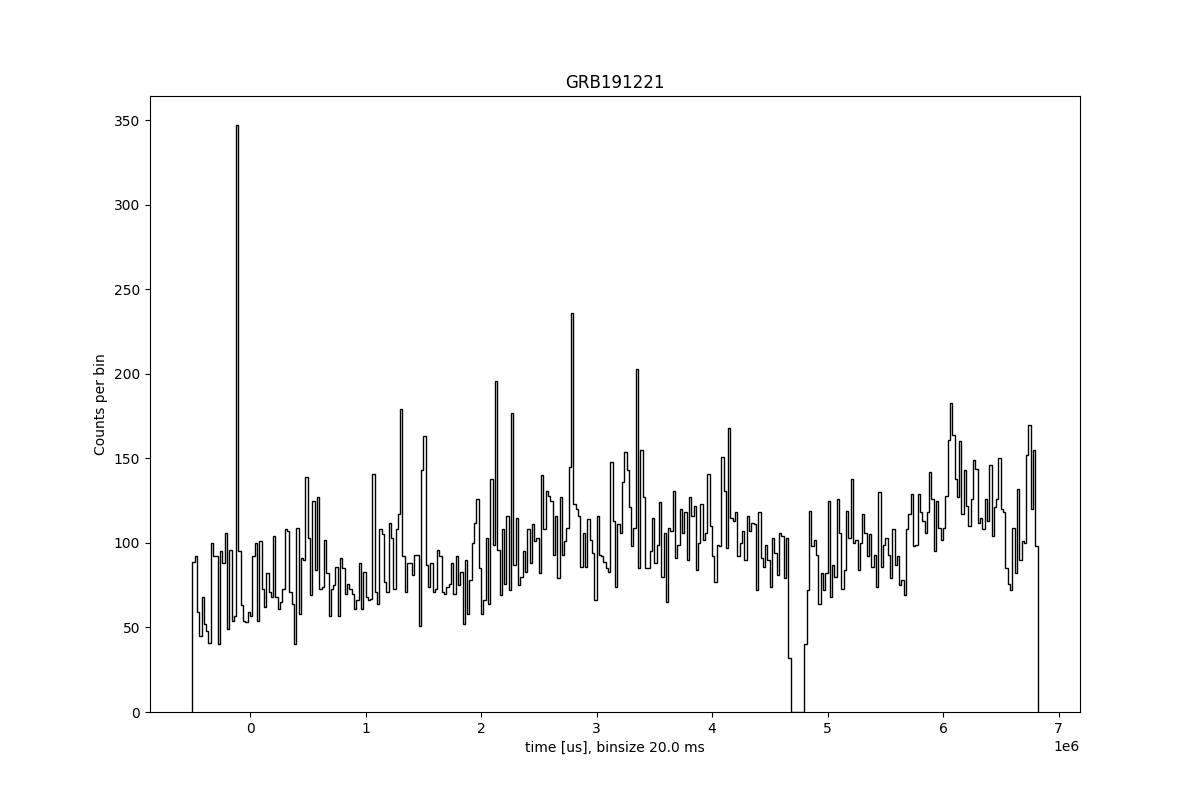

In [18]:
plot_LED(tus_arr=concat_tus_LED,T0=T0,binsize=20)
#"GRB181227":["2018.12.27_06.17.04.210500_Fulltrigger","2018_12_27_06_17_09.775992_Fulltrigger","2018_12_27_06_17_10.800851_Fulltrigger"

# Debugging

# main function

In [ ]:
# On hold for now. 
"""def main(grb_id,binsize=10000, start_GRB, end_GRB):  # filename GRB ID
    # output array for tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED må modifiseres
    # Automake by making filename a list of filenames. Then the all the outout plots will be created

    # TODO:
    # Add the extra parameters to make the get_mean work
#os.mkdir("/Users/andreas/phys/master/MATLAB/pyplots")
    trig_dict = create_triggers_dict()
    try:
        output_dir = os.mkdir("/Home/siv30/wad005/master/GRB/MATLAB/pyplots/{}".format(grb_id)) #Creating owd folder for grb_id
    except FileExistsError:
        output_dir = "/Home/siv30/wad005//master/GRB/MATLAB/pyplots/{}".format(grb_id) #selecting path if it already exists


    if type(grb_id) != str:
        raise TypeError("Input is not string")
    elif grb_id not in trig_dict:
        raise LookupError("grb_id not in dictionary")
    else:
        try:
            LED_filename = trig_dict[grb_id][0]
            HED_filename = trig_dict[grb_id][1]
            if type(LED_filename) == float and math.isnan(LED_filename):
                print("LED file not found. Plotting only HED")
                plot_HED(HED_filename,output_dir,grb_id) #output path is not required
                
            elif type(HED_filename) == float and math.isnan(HED_filename):
                print("HED file not found. Plotting only LED")
                plot_LED(LED_filename,output_dir,grb_id)
            else:
                plot_LED(LED_filename,output_dir,grb_id)
                plot_HED(HED_filename,output_dir,grb_id)
        except:
            print("Something went wrong")
    """
    

# Purgatory

In [ ]:
"""# Not in use
def get_filenames(path):
    return sorted((f for f in os.listdir(path) if not f.startswith(".")), key=str.lower)"""

In [ ]:
#Old plot_HED function
"""
def plot_HED(HED_filename, output_dir,grb_id):
    tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, DetCol_HED = read_matlab_file_with_BGO_data(HED_filename)

    fig0, (ax0, ax1) = plt.subplots(
        2, 1, figsize=(8, 8), sharex=True, sharey=False)
    ax0.set_title("HED")

    ax0.scatter(tus_HED, erg_HED)
    ax0.set_xlabel("time [us]")
    ax0.set_ylabel("Energy channel")

    binsize = 10000  # us --> 10 ms bin
    ax1.hist(tus_HED, bins=np.arange(
        min(tus_HED), max(tus_HED)+binsize, binsize))
    ax1.set_xlabel("time [us]")
    ax1.set_ylabel("Counts per bin")
    
    output_dir_hed = output_dir + "/{}_HED".format(grb_id)
    print(output_dir_hed)
    plt.savefig(output_dir + "/{}_HED".format(grb_id)) #path where plot is saved
"""

In [ ]:
"""def sorting(l1, l2):
    # l1 and l2 has to be numpy arrays
    idx = np.argsort(l1)
    return l1[idx], l2[idx]"""

In [ ]:
"""tus1_zip, erg1_zip = zip(*sorted(zip(tus1_ex, erg1_ex))) #Sorted and coherent arrays

tus1_zip = np.asarray(tus1_zip)
erg1_zip = np.asarray(erg1_zip)

############# tus2

tus2_zip, erg2_zip = zip(*sorted(zip(tus2_ex, erg2_ex))) #Sorted and coherent arrays

tus2_zip = np.asarray(tus2_zip)
erg2_shift_zip = np.asarray(erg2_zip)

tus2_shift_zip = tus2_zip + deltaT.total_seconds()*1e6 #applying deltaT"""

In [ ]:
"""def coherence_sort(tus1=None,tus2=None,erg1=None,erg2=None):
    Sorting two arrays that are coherent. 
    returning: 
    
    flag <bool> 
    flag == True: tus1_sorted,tus2_sorted,erg1_sorted,erg2_sorted
    flag == False: IndexError 
    
    ############# tus1 & erg1
    index_sort1 = np.argsort(tus1, kind="mergesort") # sorting tus in increasing order

    tus1_sorted = tus1_ex[index_sort1]
    erg1_sorted = erg1_ex[index_sort1] #Making sure that the are coherent

    ############# tus2 & erg2
    index_sort2 = np.argsort(tus2, kind="mergesort") # sorting tus in increasing order

    tus2_sorted = tus2[index_sort2] #Making sure that the are coherent
    erg2_sorted = erg2[index_sort2]
    
    try:
        flag = np.all(index_sort1 == np.arange(0,len(tus1))) and np.all(index_sort2 == np.arange(0,len(tus2))) and np.all(erg1_sorted == erg1) and np.all(erg2_sorted == erg2)
        if flag == False:
            raise IndexError("If there is no change to tus1 and tus2, there shall not be any changes to erg1 and erg2")
        else:
            return tus1_sorted,tus2_sorted,erg1_sorted,erg2_sorted
    except IndexError as e:
        return print(e)""